# Load data, define model

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

#Define parameters 

#### Choose model ####

exp = 'Vienna_5DataSets_1.1_deep' # must be available in the models folder

#### Define data folder ####

path_to_folder = 'Vol5_DICOM_Ice73'

#### Load data and brain mask ####

with h5py.File(path_to_folder+'/CombinedCSI.mat', 'r') as f:
    grp = f['csi']            
    data = grp['Data'][:]   
    # this has shape 840, 35, 64, 64
    # bring to desired shape 64 64 35 840 next:
    data = data.transpose(3,2,1,0)
    data_real = data['real']
    data_imag = data['imag']
    data_complex = data_real+ 1j*data_imag

    #next fourier transform FID domain to spectral domain
    spectra = np.fft.fftshift(np.fft.fft(data_complex, axis=-1), axes=-1)

    # load brain mask:
    brainmask = f['mask'][:]
    brainmask = brainmask.transpose(2,1,0)

#### Load lipid mask ####
img = nib.load(path_to_folder+'/maps/mask_lipid.mnc')
skmask = img.get_fdata()  # get image as a NumPy array
skmask = skmask.transpose(2,1,0)

headmask = brainmask + skmask 

# Korbinian

In [1]:
# # load spectra
# img = nib.load('VonKorbinian/spectra.nii.gz')
# spectra = img.dataobj[:] 

# #load brainmask
# bm = nib.load('VonKorbinian/brainmask.nii.gz')
# brainmask = bm.dataobj[:] 

# # load lipid mask
# lm = nib.load('VonKorbinian/lipid_mask.nii.gz')
# skmask = lm.dataobj[:] 

# headmask = brainmask + skmask 


In [2]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio

model_dir = os.path.abspath(f'../models/{exp}')
src_dir   = os.path.join(model_dir, 'src')
sys.path.insert(0, model_dir)
sys.path.insert(0, src_dir)

# compute lipid projection / lipid removal operator

In [ ]:
import numpy as np

# ------------------------------------------------------------------
# 1)  Daten vorbereiten  
T        = spectra.shape[-1]                 # 960
Data_rf  = spectra.reshape(-1, T)            # (Nvox, 960)
lipid_rf = Data_rf[skmask.flatten() > 0, :]  # scalp-Voxels

# ------------------------------------------------------------------
# 2)  Hilfsfunktionen
def diag_mean(beta, M):
    """⟨diag⟩ von (I + β M)⁻¹  – ohne target-Abzug."""
    RemOP = np.linalg.inv(np.eye(M.shape[0]) + beta * M)
    return np.mean(np.abs(np.diag(RemOP)))

def find_beta_bisect(lipid_rf, target=0.938, tol=5e-3, max_iter=60): #CAUTION: Dont change the target value of 0.938, because WALINET was only trained with this value
    """
    Bracketing/Bisection für β → erfüllt |diag_mean(β) - target| ≤ tol.
    Liefert β und die bereits berechnete Matrix M.
    """
    M = lipid_rf.conj().T @ lipid_rf          # (T×T), positiv definit

    # ----- Bracket-Suche:  g(β_low) > target > g(β_high)
    beta_low, beta_high = 0.0, 1e-10          # klein anfangen
    g_high = diag_mean(beta_high, M)
    while g_high > target:                    # solange noch zu groß
        beta_high *= 2.0
        g_high = diag_mean(beta_high, M)
        if beta_high > 1e12:                  # reiner Sicherheitsstopp
            raise RuntimeError("Bracket-Suche schlug fehl – target evtl. > g(0)")
    
    # ----- Bisection
    for _ in range(max_iter):
        beta_mid = 0.5 * (beta_low + beta_high)
        g_mid    = diag_mean(beta_mid, M)
        if abs(g_mid - target) <= tol:
            return beta_mid, M
        if g_mid > target:       # noch zu groß  ⇒ β rauf
            beta_low = beta_mid
        else:                    # zu klein      ⇒ β runter
            beta_high = beta_mid
    raise RuntimeError("Gewünschte Toleranz nicht erreicht")

# ------------------------------------------------------------------
# 3)  β bestimmen und Operatoren berechnen
beta, M = find_beta_bisect(lipid_rf)          # garantiert konvergent
RemOP   = np.linalg.inv(np.eye(T) + beta * M)
LipidRem_Operator_ff  = RemOP
LipidProj_Operator_ff = np.eye(T) - RemOP

print(f"Achieved diag-mean = {np.mean(np.abs(np.diag(RemOP))):.4f} at β = {beta:.2e}")


Achieved diag-mean = 0.9377 at β = 4.92e-06


In [ ]:
import os
import sys
import time

import numpy as np
import torch

eps = 1e-8  # Small epsilon to avoid division by zero

def runNNLipRemoval2(device, exp, spectra, LipidProj_Operator_ff, headmask, batch_size=200):
    """
    Run your trained yModel to remove lipids from `spectra`.

    Args:
        device: torch.device
        exp:    str, name of your experiment folder under ../models/
        spectra: np.ndarray, shape (X,Y,Z,T), complex after fft+fftshift
        LipidProj_Operator_ff: np.ndarray, shape (T,T), lipid‐projection operator
        headmask: np.ndarray, shape (X,Y,Z), boolean or 0/1 mask for voxels
        batch_size: int, inference batch size
    Returns:
        out_vol: np.ndarray, shape (X,Y,Z,T), lipid‐removed spectra
    """
    t0 = time.time()
    X, Y, Z, T = spectra.shape
    Nvox = X * Y * Z

    # — Flatten and select mask voxels
    S_flat    = spectra.reshape(Nvox, T)                  # (Nvox, T)
    mask_flat = (headmask.flatten() > 0)                  # (Nvox,)
    selected  = np.where(mask_flat)[0]                    # indices of voxels to process

    lip_arr      = S_flat[selected, :]                    # (Nsel, T)
    lipProj_arr  = lip_arr.dot(LipidProj_Operator_ff)     # (Nsel, T)

    # — Convert to torch complex tensors on device
    lip_t     = torch.tensor(lip_arr,     dtype=torch.cfloat, device=device)
    lipProj_t = torch.tensor(lipProj_arr, dtype=torch.cfloat, device=device)

    # — Filter out any rows with NaNs
    valid_mask = (~torch.isnan(lip_t).any(dim=1) &
                  ~torch.isnan(lipProj_t).any(dim=1))
    lip_t     = lip_t[valid_mask]
    lipProj_t = lipProj_t[valid_mask]
    valid_idx = np.where(valid_mask.cpu().numpy())[0]    # indices into `selected`

    # — Dynamically import your model code, just like in your original
    for sub in os.listdir(f'../models/{exp}'):
        if sub.startswith("src"):
            sys.path.insert(0, os.path.abspath(f'../models/{exp}'))
            sys.path.insert(0, os.path.abspath(f'../models/{exp}/{sub}'))
            from config    import params
            from src.model import yModel
            break

    # — Instantiate and load your trained yModel
    model = yModel(nLayers    = params["nLayers"],
                   nFilters   = params["nFilters"],
                   dropout    = 0,
                   in_channels  = params["in_channels"],
                   out_channels = params["out_channels"])
    params["path_to_model"] = f"../models/{exp}/"
    ckpt = torch.load(params["path_to_model"] + 'model_last.pt',
                      map_location=device)
    model.load_state_dict(ckpt)
    model.to(device).eval()

    # — Compute per-voxel energy normalization factor
    energy = torch.sqrt(torch.sum((lip_t - lipProj_t).abs()**2, dim=1) + eps)[:, None]
    energy = torch.clamp(energy, min=1e-3)

    # — Normalize and pack real/imag into channels (Nsel, 2, T)
    lip_norm     = lip_t     / energy
    lipProj_norm = lipProj_t / energy
    lip_in     = torch.stack((lip_norm.real,     lip_norm.imag),     dim=1)
    lipProj_in = torch.stack((lipProj_norm.real, lipProj_norm.imag), dim=1)

    # — Inference in batches
    Nsel = lip_t.shape[0]
    preds = torch.zeros((Nsel, 2, T), dtype=torch.float64, device='cpu')
    with torch.no_grad():
        for i in range(0, Nsel, batch_size):
            lb = lip_in[i:i+batch_size].to(device)
            lp = lipProj_in[i:i+batch_size].to(device)
            out = model(lb, lp)[:, :2, :].cpu()
            preds[i:i+batch_size] = out

    # — Reconstruct complex prediction & scale back
    pred_c = preds[:,0,:] + 1j * preds[:,1,:]   # (Nsel, T)
    pred_c = pred_c * energy.cpu()              # broadcast (Nsel,1) × (Nsel,T)

    # — Subtract predicted lipid from original
    removed = lip_t.cpu() - pred_c              # (Nsel, T)

    # — Scatter back into full volume
    full = np.zeros((Nvox, T), dtype=np.complex128)
    full_indices = selected[valid_idx]           # true flat indices in [0..Nvox)
    full[full_indices, :] = removed.numpy()
    out_vol = full.reshape(X, Y, Z, T)

    print(f"[runNNLipRemoval2] done in {time.time()-t0:.1f}s")
    return out_vol




In [6]:
# ——————————— Example usage ———————————
if __name__ == "__main__":
    # 1) Prepare device & experiment name
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 4) Run lipid removal
    Data_LipidRemoved_rrrf = runNNLipRemoval2(
        device,
        exp,
        spectra,
        LipidProj_Operator_ff,
        headmask,
        batch_size=200
    )


[runNNLipRemoval2] done in 8.4s


In [8]:
Nuisance_Free_FID_Data = np.fft.ifft(np.fft.ifftshift(Data_LipidRemoved_rrrf, axes=-1), axis=-1) # go back to FID domain

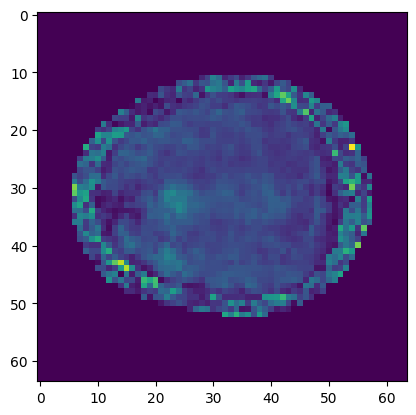

In [13]:
z, t = 20, 4

Slice = np.abs(Nuisance_Free_FID_Data)[:,:,z,t]
plt.imshow(Slice)